# ***SVC Balanced***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import os
import pickle  # For saving and loading the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score, make_scorer
import optuna
from sklearn.ensemble import RandomForestClassifier

import os
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import optuna
import joblib
import time
import numpy as np
pd.options.display.float_format = '{:.3f}'.format

In [2]:
df = pd.read_excel("../Preprocessed data.xlsx")
#df.columns
#df.head()

In [3]:
#numeric_cols = ["CAPITAL", "CONTEO_PRODUCTOS", "Cupo", "DiasMejorGestion", "DiasUltimaGestion", "EDAD", 'GRUPO', 'Mora_maxima_cliente__Asignacion', 'PgMin', 'SaldoCliente', 'SaldoVencido', 'TotalGestiones', 'TotalGestionesCD', 'TotalGestionesCI', 'TotalGestionesCompromiso', 'TotalGestionesMasivas', 'TotalGestionesNC', 'dias_mora_Asignacion', 'saldo_total', ]

In [ ]:
import os
import joblib
import pandas as pd
import numpy as np
import optuna
import time
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, StratifiedKFold

# Definir columnas numéricas para escalar
numeric_cols = ["CAPITAL", "CONTEO_PRODUCTOS", "Cupo", "DiasMejorGestion", "DiasUltimaGestion", "EDAD", 'GRUPO',
                'Mora_maxima_cliente__Asignacion', 'PgMin', 'SaldoCliente', 'SaldoVencido', 'TotalGestiones', 
                'TotalGestionesCD', 'TotalGestionesCI', 'TotalGestionesCompromiso', 'TotalGestionesMasivas',
                'TotalGestionesNC', 'dias_mora_Asignacion', 'saldo_total']

# Separar características y variable objetivo
X = df.drop(columns=["Cuenta", "Estado"])
y = df["Estado"]

# Dividir en conjunto de entrenamiento, validación y prueba (estratificado)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Definir nombres de archivos
model_filename = "../Models/svc_model_cv_Balanced.pkl"
study_filename = "../Study/optuna_study_SVC_cv_Balanced.pkl"
scaler_filename = "../Models/scaler_svc_Balanced.pkl"

# Función objetivo para Optuna con validación cruzada y SMOTE
def objective(trial):
    param = {
        "C": trial.suggest_loguniform("C", 1e-3, 1e3),
        "kernel": trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"]),
        "gamma": trial.suggest_categorical("gamma", ["scale", "auto"]),
    }

    f1_scores = []
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kfold.split(X_train, y_train):
        X_train_fold, y_train_fold = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val_fold, y_val_fold = X_train.iloc[val_idx], y_train.iloc[val_idx]

        # Aplicar SMOTE solo en el set de entrenamiento del fold
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

        # Escalar los datos
        scaler = StandardScaler()
        X_train_resampled[numeric_cols] = scaler.fit_transform(X_train_resampled[numeric_cols])
        X_val_fold[numeric_cols] = scaler.transform(X_val_fold[numeric_cols])
        
        # Entrenar modelo
        model = SVC(**param, probability=True, random_state=42)
        model.fit(X_train_resampled, y_train_resampled)
        
        # Evaluar en validación
        y_val_pred = model.predict(X_val_fold)
        f1_scores.append(f1_score(y_val_fold, y_val_pred, average="weighted"))
    
    return np.mean(f1_scores)

# Intentar cargar el estudio de Optuna si existe
if os.path.exists(study_filename):
    print(f"Study found. Loading from {study_filename}...")
    study_svc_balanced = joblib.load(study_filename)
else:
    print("Study not found. Creating a new one...")
    pruner = optuna.pruners.MedianPruner()
    study_svc_balanced = optuna.create_study(direction="maximize", pruner=pruner)
    start_time = time.time()
    study_svc_balanced.optimize(objective, n_trials=50)
    end_time = time.time()
    joblib.dump(study_svc_balanced, study_filename)
    print(f"Study saved as {study_filename}")
    print(f"Optimization time: {end_time - start_time:.2f} seconds")

# Obtener los mejores parámetros
best_params = study_svc_balanced.best_params

# Aplicar SMOTE al conjunto de entrenamiento completo
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Escalar los datos
scaler_final = StandardScaler()
X_train_resampled[numeric_cols] = scaler_final.fit_transform(X_train_resampled[numeric_cols])
X_val[numeric_cols] = scaler_final.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler_final.transform(X_test[numeric_cols])

# Guardar el escalador
joblib.dump(scaler_final, scaler_filename)

# Entrenar modelo final
svc_model_balanced = SVC(**best_params, probability=True, random_state=42)
svc_model_balanced.fit(X_train_resampled, y_train_resampled)
joblib.dump(svc_model_balanced, model_filename)
print(f"Model saved as {model_filename}")

# Evaluación en validación
y_val_pred = svc_model_balanced.predict(X_val)
print("\nValidation Metrics:")
print(f"F1-Score (Validation): {f1_score(y_val, y_val_pred, average='weighted'):.4f}")
print(classification_report(y_val, y_val_pred))

# Matriz de confusión en validación
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
disp_val = ConfusionMatrixDisplay(conf_matrix_val, display_labels=svc_model_balanced.classes_)
disp_val.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Validation Set)")
plt.show()


[I 2025-02-20 10:49:04,609] A new study created in memory with name: no-name-2b15e65c-a1d7-43a9-a1c7-c81b4b3b69e6


Study not found. Creating a new one...


/tmp/ipykernel_3337819/660743088.py:40: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "C": trial.suggest_loguniform("C", 1e-3, 1e3),
/tmp/ipykernel_3337819/660743088.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val_fold[numeric_cols] = scaler.transform(X_val_fold[numeric_cols])
/tmp/ipykernel_3337819/660743088.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [5]:
from reporte_metricas import guardar_reporte

guardar_reporte(y_val, y_val_pred, "SVC Model", "./Metrics/Train_Metrics.csv", "./Metrics/Train_Metrics.json")

📂 Reporte de SVC Model guardado correctamente.


## ***Test Metrics***

In [6]:
# **Evaluación en el conjunto de prueba**
y_test_pred = svc_model.predict(X_test)

# Calcular F1-score, reporte de clasificación y matriz de confusión para `test`
f1_test = f1_score(y_test, y_test_pred, average="weighted")
print("\nTest Metrics:")
print(f"F1-Score (Test): {f1_test:.4f}")
print(classification_report(y_test, y_test_pred))




Test Metrics:
F1-Score (Test): 0.8581
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      3212
           1       0.78      0.67      0.72       969
           2       0.75      0.63      0.68       586

    accuracy                           0.86      4767
   macro avg       0.81      0.75      0.78      4767
weighted avg       0.86      0.86      0.86      4767



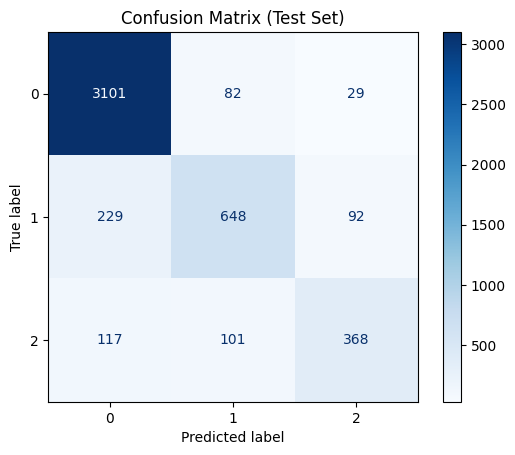

In [7]:
# Matriz de confusión para `test`
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(conf_matrix_test, display_labels=svc_model.classes_)
disp_test.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.show()

## ***Optuna Visualization***

In [8]:
optuna.visualization.plot_optimization_history(study_svc)

In [9]:
optuna.visualization.plot_parallel_coordinate(study_svc)

In [10]:
# Extract F1-scores from each trial in the study
f1_scores = [study_svc.trials[i].value for i in range(len(study_svc.trials))]  # Get the F1-score for each trial

# Create a plotly figure
fig = go.Figure()

# Add a line plot to the figure with the F1-scores
fig.add_trace(go.Scatter(
    x=list(range(len(study_svc.trials))),  # X-axis: Trial number
    y=f1_scores,  # Y-axis: F1-score values
    mode='markers+lines',  # Display both markers and lines
    name='F1-score',  # Label for the line
    line=dict(color='blue'),  # Line color
    marker=dict(color='blue', size=6)  # Marker style
))

# Update layout for the plot
fig.update_layout(
    title="F1-Score Evolution During Optuna Optimization",  # Title of the plot
    xaxis_title="Trial",  # Label for X-axis
    yaxis_title="F1-Score",  # Label for Y-axis
    template="plotly_dark",  # Use dark template for better visibility
    showlegend=False  # Hide legend
)

# Show the plot
fig.show()


In [11]:
optuna.visualization.plot_slice(study_svc, params=['C', 'kernel', 'gamma'])


In [12]:
optuna.visualization.plot_param_importances(study_svc)

In [13]:
svc_model

SVC(C=71.00753181553976, probability=True, random_state=42)

In [14]:
from reporte_metricas import guardar_reporte

guardar_reporte(y_test, y_test_pred, "SVC Model", "./Metrics/Test_Metrics.csv", "./Metrics/Test_Metrics.json")

📂 Reporte de SVC Model guardado correctamente.
